In [1]:
import sympy as sp
from sympy import cos as c, sin as s, pi, Function as f, Matrix as M
import numpy as np
from scipy.integrate import odeint

# Define the independent variable
x, y, t, l1, l2, m1, m2 = sp.symbols("x y t l1 l2 m1 m2")
L1, L2, g = sp.symbols("L1 L2 g")
q1, q2 = f("q1")(t), f("q2")(t)
c1, s1, c2, s2, c12, s12 = c(q1), s(q1), c(q2), s(q2), c(q1 + q2), s(q1 + q2)
t_diff = lambda expr: sp.diff(expr, t) if t in expr.free_symbols else expr

# Define the forward kinematics
R1 = M([[c1, -s1, 0], [s1, c1, 0], [0, 0, 1]])
T1 = M([[1, 0, l1], [0, 1, 0], [0, 0, 1]])
R2 = M([[c2, -s2, 0], [s2, c2, 0], [0, 0, 1]])
T2 = M([[1, 0, l2], [0, 1, 0], [0, 0, 1]])
Q01 = R1 * T1
Q12 = R2 * T2
Q02 = Q01 * Q12
Q02 = Q02.applyfunc(sp.simplify)
Ph = M([[x], [0], [1]])

dq1 = q1.diff(t)
dq2 = q2.diff(t)
ddq1 = dq1.diff(t)
ddq2 = dq2.diff(t)
tau1, tau2 = sp.symbols("tau1 tau2")

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{q}_i} - \frac{\partial L}{\partial q_i} = \tau_i$$
$$M(q)\ddot{q} + C(q,\dot{q})\dot{q} + G(q) = \tau$$


In [2]:
m_t = M(
    [
        [
            m1 * L1**2 + m2 * (L1**2 + 2 * L1 * L2 * c2 + L2**2),
            m2 * (L1 * L2 * c2 + L2**2),
        ],
        [m2 * (L1 * L2 * c2 + L2**2), m2 * L2**2],
    ]
)
c_t_td = M(
    [[-m2 * L1 * L2 * s2 * (2 * dq1 * dq2 * dq2**2)], [m2 * L1 * L2 * s2 * dq1**2]]
)
g_t = M(
    [
        [(m1 + m2) * g * L1 * c(q1) + m2 * g * L2 * c(q1 + q2)],
        [m2 * g * L2 * c(q1 + q2)],
    ]
)

In [3]:
eq = m_t * M([[ddq1], [ddq2]]) + c_t_td + g_t - M([[tau1], [tau2]])
eq


Matrix([
[-2*L1*L2*m2*sin(q2(t))*Derivative(q1(t), t)*Derivative(q2(t), t)**3 + L1*g*(m1 + m2)*cos(q1(t)) + L2*g*m2*cos(q1(t) + q2(t)) + m2*(L1*L2*cos(q2(t)) + L2**2)*Derivative(q2(t), (t, 2)) - tau1 + (L1**2*m1 + m2*(L1**2 + 2*L1*L2*cos(q2(t)) + L2**2))*Derivative(q1(t), (t, 2))],
[                                                                                                L1*L2*m2*sin(q2(t))*Derivative(q1(t), t)**2 + L2**2*m2*Derivative(q2(t), (t, 2)) + L2*g*m2*cos(q1(t) + q2(t)) + m2*(L1*L2*cos(q2(t)) + L2**2)*Derivative(q1(t), (t, 2)) - tau2]])

In [4]:
sols = sp.solve(eq, [ddq1, ddq2], rational=False, simplify=True)
ddq1_sol = sols[ddq1]
ddq2_sol = sols[ddq2]


> convert to state space form:

Assume $x=\begin{bmatrix} q & \dot{q} \end{bmatrix}^T$, then we have:

$$
\begin{bmatrix}x_1 \\ x_2 \\ x_3 \\ x_4\end{bmatrix} = \begin{bmatrix} q_1 \\ q_2 \\ \dot{q}_1 \\ \dot{q}_2 \end{bmatrix}
\Longrightarrow
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4\end{bmatrix} = \begin{bmatrix} x_3 \\ x_4 \\ \ddot{q}_1 \\ \ddot{q}_2 \end{bmatrix} = \begin{bmatrix} x_3 \\ x_4 \\ M(q)^{-1}(\tau - C(q,\dot{q})\dot{q} - G(q)) \end{bmatrix}
$$

In other words, we have:
$$\dot{x} = \begin{bmatrix} \dot{q} \\ M(q)^{-1}(\tau - C(q,\dot{q})\dot{q} - G(q)) \end{bmatrix}$$


In [5]:
x1, x2, x3, x4 = sp.symbols("x1 x2 x3 x4", cls=sp.Function)
x1, x2, x3, x4 = x1(t), x2(t), x3(t), x4(t)
# x1_d, x2_d, x3_d, x4_d = sp.symbols(r'\dot{x}_1 \dot{x}_2 \dot{x}_3 \dot{x}_4')
# x = M([x1, x2, x3, x4])
# x_d = M([x1_d, x2_d, x3_d, x4_d])
# substitute the symbols with the states
x1_d = x3
x2_d = x4
x3_d = ddq1_sol.subs({q1: x1, q2: x2, dq1: x3, dq2: x4})
x4_d = ddq2_sol.subs({q1: x1, q2: x2, dq1: x3, dq2: x4})
# define functions for the dynamics
x1_d_f = sp.lambdify(x1.diff(t), x1.diff(t))
x2_d_f = sp.lambdify(x2.diff(t), x2.diff(t))
x3_d_f = sp.lambdify([t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2], x3_d)
x4_d_f = sp.lambdify([t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2], x4_d)

In [40]:
type(x1_d_f(0.0))

float

In [43]:
# define interface to evaluate the dynamics
def dxdt(x, t, tau1, tau2, m1, m2, g, L1, L2):
    x1, x2, x3, x4 = x
    return [
        x1_d_f(x3), # x1_d = q1_d
        x3_d_f(t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2), # x3_d = q1_dd
        x2_d_f(x4), # x2_d = q2_d
        x4_d_f(t, x1, x2, x3, x4, tau1, tau2, m1, m2, g, L1, L2), # x4_d = q2_dd
    ]

In [45]:
time = np.linspace(0, 40, 1001)
g = 9.81
m1 = 2
m2 = 1
L1_ = 2
L2_ = 1
ans = odeint(dxdt, y0=[0.0, 0.0, np.pi/2, 0.0], t=time, args=(1, 0, m1, m2, g, L1_, L2_))

In [46]:
x1_sym = ans.T[0]
x2_sym = ans.T[2]
x3_sym = ans.T[1]
x4_sym = ans.T[3]


In [47]:
# Replace the symbols with the states
Q02 = Q02.subs({l1: L1, l2: L2, q1: x1, q2: x2})
P = (Q02*M([[0], [0], [1]]))[0:2, 0]
# Define the forward kinematics as a function of the states
fk = sp.lambdify([x1, x2, L1, L2], P)

In [48]:
x1_sym

array([0.])

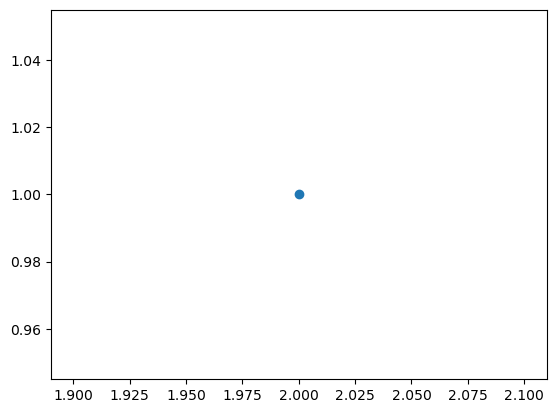

In [49]:
import matplotlib.pyplot as plt
p = fk(x1_sym, x2_sym, L1_, L2_)
p = p[:, 0]
plt.scatter(p[0], p[1])

In [8]:
# m_t_inv = m_t.inv()
# eq = (m_t_inv*(M([[tau1],[tau2]])-c_t_td-g_t)).applyfunc(sp.simplify)
# eq

(L2*(2*L1*L2*m2*x3*x4**3*sin(x2) - L1*g*(m1 + m2)*cos(x1) - L2*g*m2*cos(x1 + x2) + tau1) + (L1*cos(x2) + L2)*(L1*L2*m2*x3**2*sin(x2) + L2*g*m2*cos(x1 + x2) - tau2))/(L1**2*L2*(m1 + m2\*sin(x2)**2))

(-L2*m2*(L1*cos(x2) + L2)*(2*L1*L2*m2*x3*x4\*\*3*sin(x2) - L1*g*(m1 + m2)*cos(x1) - L2*g*m2*cos(x1 + x2) + tau1) - (L1*L2*m2*x3\*\*2*sin(x2) + L2*g*m2*cos(x1 + x2) - tau2)*(L1**2\*m1 + L1**2*m2 + 2*L1*L2*m2*cos(x2) + L2\*\*2*m2))/(L1**2\*L2**2*m2*(m1 + m2\*sin(x2)\*\*2))


In [9]:
x3_dot = (
    L2
    * (
        2 * L1 * L2 * m2 * x3 * x4**3 * s(x2)
        - L1 * g * (m1 + m2) * c(x1)
        - L2 * g * m2 * c(x1 + x2)
        + tau1
    )
    + (L1 * c(x2) + L2)
    * (L1 * L2 * m2 * x3**2 * s(x2) + L2 * g * m2 * c(x1 + x2) - tau2)
) / (L1**2 * L2 * (m1 + m2 * s(x2) ** 2))
x4_dot = (
    -L2
    * m2
    * (L1 * c(x2) + L2)
    * (
        2 * L1 * L2 * m2 * x3 * x4**3 * s(x2)
        - L1 * g * (m1 + m2) * c(x1)
        - L2 * g * m2 * c(x1 + x2)
        + tau1
    )
    - (L1 * L2 * m2 * x3**2 * s(x2) + L2 * g * m2 * c(x1 + x2) - tau2)
    * (L1**2 * m1 + L1**2 * m2 + 2 * L1 * L2 * m2 * c(x2) + L2**2 * m2)
) / (L1**2 * L2**2 * m2 * (m1 + m2 * s(x2) ** 2))

In [10]:
x3_dot


(tau1 + (2*cos(x2(t)) + 1)*(-tau2 + 2*x3(t)**2*sin(x2(t)) + 9.81*cos(x1(t) + x2(t))) + 4*x3(t)*x4(t)**3*sin(x2(t)) - 9.81*cos(x1(t) + x2(t)) - 58.86*cos(x1(t)))/(4*sin(x2(t))**2 + 8)

In [11]:
# define interface for the forward kinematics
def forward_kinematics(q1t, q2t, L1, L2):
    """
    Returns the position of the end effector given the angles of the two links.
    """
    fwd_subs = {l1: L1, l2: L2, q1: q1t, q2: q2t}
    p = Q02 * M([[0], [0], [1]])
    p[0] = p[0].subs(fwd_subs)
    p[1] = p[1].subs(fwd_subs)
    return np.array(p[:2]).astype(np.float64).flatten()

In [12]:
p = forward_kinematics(0, 0, 1, 1)
p.shape


(2,)

In [13]:
# simulate the system
import numpy as np


def simulate(x0, tau1_t, tau2_t, dt=0.01, t_end=10, L1_=1, L2_=1, M1=1, M2=1, G=9.81):
    """
    Simulate the double pendulum system for a given time.
    Args:
        x0: initial state vector
        tau1_t: torque applied to the first link
        tau2: torque applied to the second link
        dt: time step
        t_end: end time
    """
    # initialize the state vector
    x = x0
    # initialize the time vector
    t = np.arange(0, t_end, dt)
    # initialize the state vector history
    x_hist = np.zeros((len(t), len(x0)))
    # initialize the torque vector history
    tau_hist = np.zeros((len(t), 2))
    # initialize the position vector history
    p_hist = np.zeros((len(t), 2))
    # initialize the velocity vector history
    v_hist = np.zeros((len(t), 2))
    # initialize the acceleration vector history
    a_hist = np.zeros((len(t), 2))
    # initialize the control vector history
    u_hist = np.zeros((len(t), 2))
    # initialize the time step
    i = 0
    # simulate the system
    for i in range(len(t)):
        # save the current state
        x_hist[i] = x.T
        # save the current torque
        tau_hist[i] = np.array([tau1_t, tau2_t])
        # save the current position
        p_hist[i] = forward_kinematics(x[0, 0], x[1, 0], L1_, L2_)[0:2]
        # save the current velocity
        v_hist[i] = np.array([x[2, 0], x[3, 0]])
        # save the current acceleration
        x3_d
        a_hist[i] = np.array(
            [
                x3_dot.subs(
                    {
                        x1: x[0, 0],
                        x2: x[1, 0],
                        x3: x[2, 0],
                        x4: x[3, 0],
                        L1: L1_,
                        L2: L2_,
                        m1: M1,
                        m2: M2,
                        g: G,
                        tau1: tau1_t,
                        tau2: tau2_t,
                    }
                ),
                x4_dot.subs(
                    {
                        x1: x[0, 0],
                        x2: x[1, 0],
                        x3: x[2, 0],
                        x4: x[3, 0],
                        L1: L1_,
                        L2: L2_,
                        m1: M1,
                        m2: M2,
                        g: G,
                        tau1: tau1_t,
                        tau2: tau2_t,
                    }
                ),
            ]
        )
        # save the current control
        u_hist[i] = np.array([tau1_t, tau2_t])
        # update the state
        x = (
            x
            + x_dot.subs(
                {
                    x1: x[0, 0],
                    x2: x[1, 0],
                    x3: x[2, 0],
                    x4: x[3, 0],
                    L1: L1_,
                    L2: L2_,
                    m1: M1,
                    m2: M2,
                    g: G,
                    tau1: tau1_t,
                    tau2: tau2_t,
                }
            )
            * dt
        )
    return t, x_hist, tau_hist, p_hist, v_hist, a_hist, u_hist

In [14]:
x0 = np.array([[0], [0], [0], [0]])
tau1_t = 1
tau2_t = 0
t, x_hist, tau_hist, p_hist, v_hist, a_hist, u_hist = simulate(
    x0, tau1_t, tau2_t, dt=0.01, t_end=1, G=0
)

NameError: name 'x_dot' is not defined

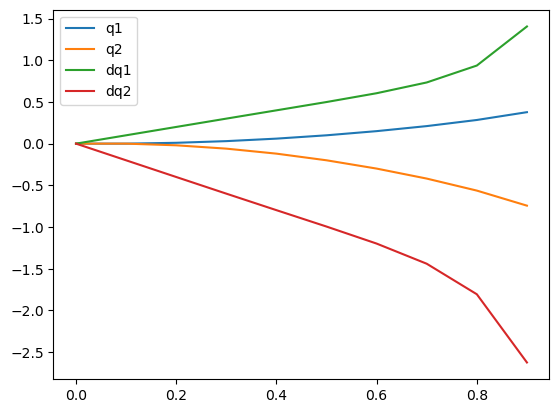

In [ ]:
import matplotlib.pyplot as plt

plt.plot(t, x_hist[:, 0], label="q1")
plt.plot(t, x_hist[:, 1], label="q2")
plt.plot(t, x_hist[:, 2], label="dq1")
plt.plot(t, x_hist[:, 3], label="dq2")
plt.legend()
plt.show()

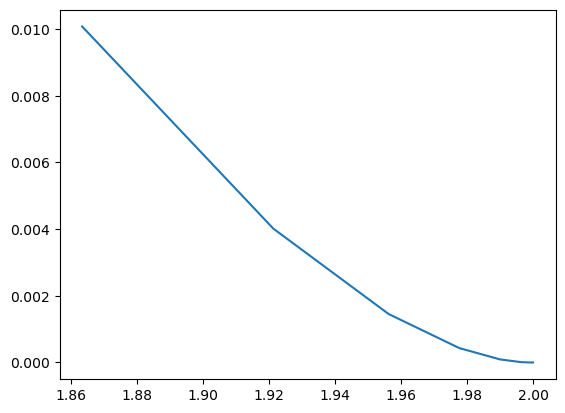

In [ ]:
# plot the position of the end effector
plt.plot(p_hist[:, 0], p_hist[:, 1])
plt.show()